In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.preprocessing import normalize
from numpy.linalg import det
from numpy.linalg import inv

import torch
import torch.nn as nn
import torch.optim as optim
import math

from itertools import product

### Read Data

In [35]:
data_path = 'cifar-10-python/cifar-10-batches-py/'

def get_training_set():
    training_set = {}
    for i in range(1, 6):
        batch_file_name = 'data_batch_' + str(i)
        with open(data_path+batch_file_name, 'rb') as fp:
            batch = pickle.load(fp, encoding='bytes')
            if training_set:
                training_set['labels'].extend(batch[b'labels'])
                training_set['data'] = np.vstack((training_set['data'], batch[b'data']))
            else:
                training_set['data'] = batch[b'data']
                training_set['labels'] = batch[b'labels']
    training_set['labels'] = np.array(training_set['labels']).reshape(1, -1)
    return training_set

def get_test_set():
    test_set = {}
    batch_file_name = 'test_batch'
    with open(data_path+batch_file_name, 'rb') as fp:
        batch = pickle.load(fp, encoding='bytes')
        test_set['labels'] = np.array(batch[b'labels']).reshape(1, -1)
        test_set['data'] = batch[b'data']
    return test_set
    


training_set = get_training_set()
test_set = get_test_set()
print("Training set:")
print(training_set['data'].shape, training_set['labels'].shape)
print("Test set:")
print(test_set['data'].shape, test_set['labels'].shape)

Training set:
(50000, 3072) (1, 50000)
Test set:
(10000, 3072) (1, 10000)


In [36]:
def show_imgs(data, r=[i for i in range(20)]):
    rows = math.ceil(len(r)/10)
    fig, axs = plt.subplots(rows, 10)
    
    for ind in r:
        row = ind // 10
        col = ind % 10
        img = data[ind].reshape(3, 32,32).transpose(1,2,0)
        axs[row, col].yaxis.set_visible(False)
        axs[row, col].xaxis.set_visible(False)
        axs[row, col].imshow(img)
    fig.tight_layout()

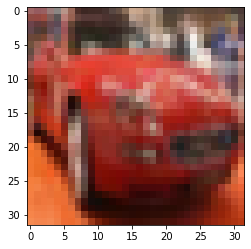

In [37]:
plt.imshow(training_set['data'][5].reshape(3, 32, 32).transpose(1,2,0))

### PCA

In [38]:

# [Vsort,Dsort] = eigsort(V, eigvals)
#
# Sorts a matrix eigenvectors and a array of eigenvalues in order 
# of eigenvalue size, largest eigenvalue first and smallest eigenvalue
# last.
#
# Example usage:
# di, V = np.linarg.eig(L)
# Vnew, Dnew = eigsort(V, di)
#
# Tim Marks 2002

def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

# normc(M) normalizes the columns of M to a length of 1.
# Funcion from homework 5
def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

def get_pca_data(D, data, plot=False, plot_indexes=[5000+i for i in range(20)]):
    """
    D: dimensions of the results,
    data: original data, d * n
    return: D * n
    """
    print("Start PCA...")
    n = data.shape[1]
    d = data.shape[0]
    mean = data.mean(axis=1, keepdims=True)
    A = data - mean
    if d <= n:
        cov = A@A.T
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        sorted_eigenvectors, Dsort = eigsort(eigenvectors, eigenvalues)
        sorted_eigenvalues = [Dsort[i][i] for i in range(Dsort.shape[0])]
    else:
        fake_cov = A.T@A 
        eigenvalues, eigenvectors = np.linalg.eig(fake_cov)
        sorted_eigenvectors, Dsort = eigsort(eigenvectors, eigenvalues)
        sorted_eigenvalues = [Dsort[i][i] for i in range(Dsort.shape[0])]
        sorted_eigenvectors = A@sorted_eigenvectors
    
    # d * D
    U = normc(sorted_eigenvectors[:, :D])
    # D * n
    c = U.T@(data - mean)
    
    if plot:
        z_tilde = U@c + mean
        show_imgs(z_tilde[:,plot_indexes].T)
    
    
    return c


Start PCA...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


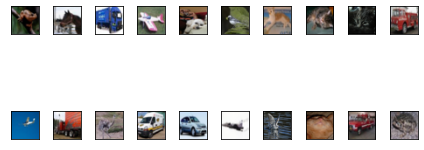

In [79]:
pca_processed_data = get_pca_data(3072, training_set['data'].T/256, plot=True)

### Autoencoder

In [6]:
default_device = torch.device('cpu')
if torch.cuda.is_available():
    default_device = torch.device('cuda:1')

class Autoencoder(nn.Module):
    
    def __init__(self, config_layers):
        """
        config_layers: e.g. [3072, 512, 128, 50, 128, 512, 3072], the numbers of neurons in each layer
        """
        super(Autoencoder, self).__init__()
        self.num_layers = len(config_layers) - 1
        self.layers = []
        for i in range(self.num_layers):
            self.layers.append(nn.Linear(config_layers[i], config_layers[i+1]))
            if i == self.num_layers/2 - 1:
                continue
            elif i == self.num_layers - 1:
                self.layers.append(nn.Sigmoid())
            else:
                self.layers.append(nn.ReLU())
        
        self.encoder = nn.Sequential(*self.layers[:self.num_layers-1])
        self.decoder = nn.Sequential(*self.layers[self.num_layers-1:])
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out
        
    def encode(self, x):
        out = x
        with torch.no_grad():
            out = self.encoder(out)
        return out
    
    def decode(self, encoding):
        out = encoding
        with torch.no_grad():
            out = self.decoder(out)
        return out    
    
        
def train_encoder(data,
                  config_layers=[3072, 512, 128, 50, 128, 512, 3072], 
                  epochs=200, 
                  lr=0.0001, 
                  batch_size=32,
                  device=default_device):
    n = data.shape[0]
    d = data.shape[1]
    num_batches = math.ceil(n/batch_size)
    
    
    model = Autoencoder(config_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.MSELoss()
    
    final_loss = 0
    for e in range(epochs):
        epoch_avg_loss = 0
        epoch_final_loss = 0
        
        for b in range(num_batches):
            batch_start = batch_size * b
            if b == num_batches-1:
                batch_data = data[batch_start:, :]
            else:
                batch_data = data[batch_start:batch_start+32, :]
            
            out = model(batch_data)
            
            loss = loss_function(out, batch_data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #output
            epoch_avg_loss += loss.item()
            epoch_final_loss = loss.item()
        epoch_avg_loss /= num_batches
        final_loss = epoch_avg_loss
        print("epoch:", e, "loss:", final_loss)
        
    return model, final_loss



In [7]:
scaled_data = torch.tensor(training_set['data']/256, dtype=torch.float, device=default_device)
def find_best_model():
    lrs = [0.001, 0.0001]
    bs = [16, 32, 64, 128]
    best_model = None
    min_loss = float('inf')
    
    for lr, bs in product(lrs, bs):
        #print("======================lr:", lr, "batch_size:", bs, "========================")
        model, loss= train_encoder(scaled_data, lr=lr, batch_size=bs)
        print("lr:", lr, "batch_size:", bs, "loss:", loss)
           
        if loss < min_loss:
            min_loss = loss
            best_model = model
     
    return best_model

#autoencoder = find_best_model()
autoencoder,_ = train_encoder(scaled_data)

epoch: 0 loss: 0.0339493445244094
epoch: 1 loss: 0.02228941089608924
epoch: 2 loss: 0.01979930066847393
epoch: 3 loss: 0.01791156999294909
epoch: 4 loss: 0.016925843806147232
epoch: 5 loss: 0.016077948201469176
epoch: 6 loss: 0.015331767536985782
epoch: 7 loss: 0.014745542147361882
epoch: 8 loss: 0.014212713109702348
epoch: 9 loss: 0.013840211790724779
epoch: 10 loss: 0.013470253923828031
epoch: 11 loss: 0.0131360767158946
epoch: 12 loss: 0.012845353950327472
epoch: 13 loss: 0.012619432878828895
epoch: 14 loss: 0.012415228532514012
epoch: 15 loss: 0.012228607815605131
epoch: 16 loss: 0.012024502557722026
epoch: 17 loss: 0.011889304428272573
epoch: 18 loss: 0.011711147479755865
epoch: 19 loss: 0.011610959834101599
epoch: 20 loss: 0.01148144722399579
epoch: 21 loss: 0.011362137440389459
epoch: 22 loss: 0.01130352438125409
epoch: 23 loss: 0.011228159462088053
epoch: 24 loss: 0.011087695158415034
epoch: 25 loss: 0.011007740430150155
epoch: 26 loss: 0.010955750746789531
epoch: 27 loss: 0.01

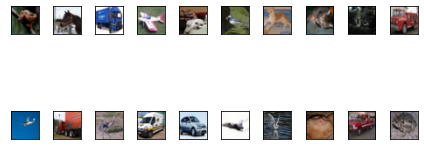

In [8]:
show_imgs(training_set['data'][5000:5020])

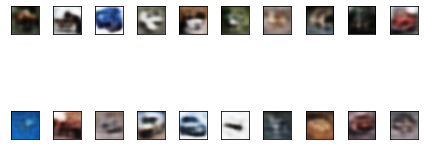

In [9]:
recovered = autoencoder.decode(autoencoder.encode(scaled_data[5000:5020, :]))
show_imgs(recovered.detach().cpu().numpy())

### GMM

In [10]:
#Modified From hw4 discussion
def gaussian(x, mu, cov):
    d = x.shape[1]
    mu = mu.reshape(1,d)
    
#     print("cov_det:", det(cov))
#     print("d:", d)
    
    dr = 1/np.sqrt((2* np.pi)**d * det(cov))
    

    dg = -np.diag((x-mu)@inv(cov)@(x-mu).T/2)
    
#     print("x-mu", x-mu)
#     print("dg50:", dg[:50])
    
    
    nr = (np.exp(dg))
    
#     print("nr50:", nr[:50])
#     print("nr_sum:", nr.sum())
#     print("dr_sum:", dr.sum())
    return nr * dr
#Modified From hw4
def recalcParams(x, gamma):
    """
    x: N *d
    gamma: K * N
    """
    #print(gamma.shape, x.shape)
    N = x.shape[0]
    K = gamma.shape[0]
    d = x.shape[1]

    # K * 1
    Nk = gamma.sum(axis=1, keepdims=True)

    # K * d
    
    mu = (gamma @ x) / Nk
    #(size 10 is different from 272)
    
    # K * 1
    pi = Nk/N

    # K * d * d
    cov = np.zeros((K, d, d))

    for k in range(K):
        sumcov = np.zeros((d, d))
        for n in range(N):
            #d*d
            sumcov += gamma[k][n] *\
            ((x[n] - mu[k]).reshape(d, 1) @ (x[n] - mu[k]).reshape(1, d))
        cov[k, :, :] = sumcov / Nk[k]

    return mu, cov, pi
# Modified from hw4
def calcRespons(x, mu, cov, pi):
    """
    Calculate Gamma(znk)

    x: N * d
    mu: K * d
    cov: K * d * d
    pi: K * 1               KmusOld = Kmus
        plotCurrent(X, Rnk, Kmus)
        time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)
    pdf: shape N

    return: Gamma: K*N
    """
    K = mu.shape[0]
    N = x.shape[0]

    #K * N
    num = np.zeros((K,N))
    for k in range(K):
        gs = gaussian(x, mu[k], cov[k])
    
#         print("pi:", pi)
#         print("gs:", gs)
#         print("gs_sum:", gs.sum())
        num[k] = pi[k] * gs

    denom = num.sum(axis=0)

    
    return num/denom
# Modified from hw4
def runGMM(K,X, Kmus, threshold=1e-2, maxiters = 1000):

    print("Start GMM...")
    
    d = X.shape[1]
    
    pi = np.array([1/K for _ in range(K)]).T
    
    cov = np.zeros((K, d, d))
    for k in range(K):
        cov[k] = np.diag([(0.4 + i * 0.004) for i in range(d)])
        
    for iter in range(maxiters):

        respons = calcRespons(X, Kmus, cov, pi)
        KmusOld = Kmus
        covOld = cov
        piOld = pi
        Kmus, cov, pi = recalcParams(X, respons)
        
        #plotCurrent(X, respons.T, Kmus)
        #check to see if the cluster centers have converged.  If so, break.
        kmus_change = np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1))))
        cov_change = np.sum(np.abs(covOld.reshape((-1, 1)) - cov.reshape((-1, 1))))
        pi_change = np.sum(np.abs(piOld.reshape((-1, 1)) - pi.reshape((-1, 1))))
        print("===============================iter:", iter, "============================")
        print("kmus change:", kmus_change)
        print("cov change:", cov_change)
        print("pi_change:", pi_change)
        if kmus_change < threshold:
#         if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6\
#             and \
#             np.sum(np.abs(covOld.reshape((-1, 1)) - cov.reshape((-1, 1)))) < 1e-6\
#             and \
#             np.sum(np.abs(piOld.reshape((-1, 1)) - pi.reshape((-1, 1)))) < 1e-6:
#             print(iter)
            
            break
            
    #TODO: plot
    return respons.T, Kmus


### PCA with GMM

In [47]:
dims = 50


# PCA
pca_data = get_pca_data(dims, training_set['data'].T).T
pca_data /= np.max(abs(pca_data))
print(pca_data.max(), pca_data.min())

# Initialize the kmus randomly in each set   
mu_indexes = [(5000*i + random.randint(0,4999)) for i in range(10)]
Kmus = pca_data[mu_indexes, :]
#print("Initialize by running kmean...")
#Rnk, Kmus = runKMeans(K, X)

#print(pca_data.max(), pca_data.min())


responsibilities, Kmus = runGMM(10, pca_data, Kmus,maxiters=150)

Start PCA...
0.9153230780732453 -1.0
Start GMM...
===============================iter: 0 ============================
kmus change: 19.022886929597888
cov change: 246.78718063179664
pi_change: 0.09538617405682578
===============================iter: 1 ============================
kmus change: 0.4793931468602638
cov change: 0.7744412567927318
pi_change: 0.048023478165006545
===============================iter: 2 ============================
kmus change: 0.9438551325753501
cov change: 1.5398638646759297
pi_change: 0.3912644185105913
===============================iter: 3 ============================
kmus change: 1.0101679146084375
cov change: 1.6630454412049451
pi_change: 0.16578080208116885
===============================iter: 4 ============================
kmus change: 0.4890917357280811
cov change: 0.9774634925387966
pi_change: 0.14444175909165632
===============================iter: 5 ============================
kmus change: 0.31079539255879446
cov change: 0.6562458896457549
pi_chang

In [48]:
y_hat = np.argmax(responsibilities, axis=1).reshape(1, -1)
show_result(y_hat, training_set['data'], training_set['labels'], 10, 10)

======================== class: 0 ===========================
[0 1 2 3 4 5 6 7 8 9]
[381  42 908 524 412 795 450 239 160  57]
======================== class: 1 ===========================
[0 1 2 3 4 5 6 7 8 9]
[ 165  313  975 1625  923 1419 1732  524  180  353]
======================== class: 2 ===========================
[0 1 2 3 4 5 6 7 8 9]
[ 703  237  232   81  398   43  173   65 1389  116]
======================== class: 3 ===========================
[0 1 2 3 4 5 6 7 8 9]
[895  22 153  13 122   5  36  12 508  24]
======================== class: 4 ===========================
[0 1 2 3 4 5 6 7 8 9]
[926 374 320 163 743 131 198 535 675 299]
======================== class: 5 ===========================
[0 1 2 3 4 5 6 7 8 9]
[816 862 255 270 357 200 240 357 983 836]
======================== class: 6 ===========================
[0 1 2 3 4 5 6 7 8 9]
[ 294 2596  156  257  154  183  292  253  698 2280]
======================== class: 7 ===========================
[0 1 2 3 4 5 6 7 8 9]
[ 38

<Figure size 720x720 with 0 Axes>

In [81]:
with open("pca_with_gmm.npy", "wb") as fp:
    np.save(fp, responsibilities)
    np.save(fp, Kmus)
    np.save(fp, y_hat)

### Autoencoder with GMM

In [12]:
# n * 50, data values' range: 0~1
data_encodings = autoencoder.encode(scaled_data).detach().cpu().numpy()
data_encodings /= np.max(abs(data_encodings))
print(data_encodings.shape)
# Initialize the kmus randomly in each segment  
mu_indexes = [(5000*i + random.randint(0,4999)) for i in range(10)]

Kmus1 = data_encodings[mu_indexes, :]
#print("Initialize by running kmean...")
#print(pca_data.max(), pca_data.min())

responsibilities1, Kmus1 = runGMM(10, data_encodings, Kmus1, maxiters = 150)

(50000, 50)
Start GMM...
===============================iter: 0 ============================
kmus change: 32.80007332619289
cov change: 281.2669326024674
pi_change: 0.1738122157371452
===============================iter: 1 ============================
kmus change: 2.1370915131866957
cov change: 5.703362672782518
pi_change: 0.0400990364585838
===============================iter: 2 ============================
kmus change: 3.443394767897437
cov change: 9.94879916482025
pi_change: 0.2432580861872369
===============================iter: 3 ============================
kmus change: 1.6216892171603798
cov change: 5.732216026504284
pi_change: 0.22282861358254127
===============================iter: 4 ============================
kmus change: 1.0093236109070016
cov change: 3.3934559014406687
pi_change: 0.1072113048284291
===============================iter: 5 ============================
kmus change: 0.7674469292755076
cov change: 2.445791509460492
pi_change: 0.08835925498211558
===============

In [52]:
def show_result(y_hat, data, labels, k, num, random=True):
    """
    num: number of image for each category
    y_hat: 1 * n
    labels: 1 * n
    """
    
    img_per_row = 10
    rows_per_class = num/img_per_row
    plt.figure(figsize=(img_per_row, rows_per_class * k))
    #plt.gray()

    indexes = [np.where(y_hat==i)[1] for i in range(k)]
    
    for i in range(k):
        print("======================== class:", i, "===========================")
        u, c = np.unique(labels[0, indexes[i]], return_counts=True)
        print(u)
        print(c)
    

In [14]:
# Autoencoding with GMM results
y_hat1 = np.argmax(responsibilities1, axis=1).reshape(1, -1)
show_result(y_hat1, training_set['data'], training_set['labels'], 10, 10)

======================== class: 0 ===========================
[0 1 2 3 4 5 6 7 8 9]
[1151  203  228   61  460   48  103  221  789  190]
======================== class: 1 ===========================
[0 1 2 3 4 5 6 7 8 9]
[ 453 2051  127  222  128  101  129  175  872 1483]
======================== class: 2 ===========================
[0 1 2 3 4 5 6 7 8 9]
[ 354   31 1520  675 1509  744 1970  339  145   38]
======================== class: 3 ===========================
[0 1 2 3 4 5 6 7 8 9]
[ 153  151  994 1830  560 1951  933  521  133  223]
======================== class: 4 ===========================
[0 1 2 3 4 5 6 7 8 9]
[612   2 448  37 416  31 172  31 216   4]
======================== class: 5 ===========================
[0 1 2 3 4 5 6 7 8 9]
[ 141 1314  174  313  217  238  436  225  265 1296]
======================== class: 6 ===========================
[0 1 2 3 4 5 6 7 8 9]
[ 379  481  442 1053  235 1065  452  895  252  892]
======================== class: 7 ========================

<Figure size 720x720 with 0 Axes>

In [ ]:
with open("autoencoder_with_gmm.npy", "wb") as fp:
    np.save(fp, responsibilities1)
    np.save(fp, Kmus1)
    np.save(fp, y_hat1)

In [74]:
import pandas as pd
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay , classification_report

In [60]:
auto_gmm = np.load("autoencoder_with_gmm.npy")
pca_gmm = np.load("pca_with_gmm.npy")
auto_gmm_df = pd.DataFrame(auto_gmm)
pca_gmm_df = pd.DataFrame(pca_gmm)

In [61]:
auto_gmm_df['Y_true'] = training_set['labels'].T
auto_gmm_df['Y_pred'] = np.argmax(auto_gmm, axis=1)
auto_gmm_df

,0,1,2,3,4,5,6,7,8,9,Y_true,Y_pred
0,9.392036e-04,6.355068e-10,9.707636e-01,6.012434e-04,1.617818e-26,1.093905e-04,7.225827e-09,2.638883e-02,1.197750e-03,2.155011e-16,6,2
1,1.608666e-35,1.159950e-01,2.285105e-24,7.532013e-06,4.416784e-143,4.683996e-02,8.371575e-01,4.218552e-09,1.354685e-08,4.094116e-97,9,6
2,3.330603e-44,1.490568e-05,1.239844e-31,3.535355e-05,1.150191e-183,3.799285e-07,2.083204e-03,1.309737e-16,9.978662e-01,2.598876e-206,9,8
3,2.259688e-03,4.170878e-10,4.646520e-02,1.706156e-07,9.499478e-01,1.562604e-09,7.459303e-13,7.578264e-06,3.071024e-06,1.316533e-03,4,4
4,2.345306e-05,9.998759e-01,1.205930e-33,8.028353e-16,4.095661e-86,4.525944e-05,7.949458e-06,4.335572e-05,4.047578e-06,2.729844e-28,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,7.590448e-08,3.233763e-10,7.481691e-21,9.841662e-19,1.410060e-40,2.987899e-13,1.724507e-15,2.125482e-07,2.431149e-19,9.999997e-01,2,9
49996,2.543458e-08,5.308195e-26,1.823293e-05,9.839201e-04,7.233667e-78,9.928591e-01,3.362099e-12,2.513187e-03,3.625503e-03,9.704298e-109,6,5
49997,6.980208e-27,1.858892e-03,6.011748e-36,3.135743e-07,1.906230e-195,1.166432e-01,1.309082e-02,1.501068e-17,8.684067e-01,1.134892e-138,9,8
49998,1.316816e-20,9.848126e-01,1.954386e-22,2.760512e-12,2.980357e-84,9.367350e-03,2.028179e-06,5.817639e-03,1.143515e-19,3.758629e-07,1,1


In [64]:
pca_gmm_df['Y_true'] = training_set['labels'].T
pca_gmm_df['Y_pred'] = np.argmax(pca_gmm, axis=1)
pca_gmm_df

,0,1,2,3,4,5,6,7,8,9,Y_true,Y_pred
0,9.344757e-01,1.565754e-02,3.067899e-08,4.419663e-42,3.648755e-02,1.201273e-02,1.931130e-04,2.700863e-05,2.800645e-05,1.118319e-03,6,0
1,9.025616e-14,5.064081e-10,2.854603e-69,0.000000e+00,9.496296e-22,4.859444e-17,2.072349e-01,7.927651e-01,1.604448e-51,9.354410e-10,9,7
2,3.539425e-13,4.452330e-03,1.834811e-113,0.000000e+00,1.869073e-12,2.061297e-08,1.842345e-02,5.248178e-01,6.880340e-34,4.523064e-01,9,7
3,4.644288e-04,1.708621e-05,3.245998e-02,4.703392e-09,5.884564e-03,5.179816e-07,1.603546e-08,2.196202e-10,9.611730e-01,3.712146e-07,4,8
4,1.238637e-26,2.905078e-15,1.747733e-19,7.410327e-78,3.842665e-04,5.515677e-05,9.995571e-01,3.461550e-06,2.625673e-46,1.261015e-08,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,3.484157e-13,4.597209e-16,9.999994e-01,7.451743e-13,1.919195e-08,6.012609e-07,5.897131e-10,5.648823e-14,1.227541e-28,2.984297e-21,2,2
49996,1.823261e-13,9.893452e-01,1.282657e-55,7.747375e-159,1.065471e-02,3.466349e-11,7.106961e-10,1.457698e-11,2.798817e-15,7.975967e-08,6,1
49997,1.869364e-27,2.663765e-07,5.508802e-94,0.000000e+00,1.618692e-09,8.825880e-12,5.558332e-01,1.305118e-02,4.268907e-52,4.311154e-01,9,6
49998,5.373147e-14,8.597287e-14,2.898014e-01,5.747749e-120,3.111105e-25,6.501326e-01,6.006437e-02,1.636868e-06,1.487634e-39,7.427359e-14,1,5


              precision    recall  f1-score   support

           0       0.33      0.23      0.27      5000
           1       0.36      0.41      0.38      5000
           2       0.21      0.30      0.25      5000
           3       0.25      0.37      0.29      5000
           4       0.21      0.08      0.12      5000
           5       0.05      0.05      0.05      5000
           6       0.07      0.09      0.08      5000
           7       0.07      0.08      0.07      5000
           8       0.02      0.02      0.02      5000
           9       0.02      0.01      0.02      5000

    accuracy                           0.16     50000
   macro avg       0.16      0.16      0.16     50000
weighted avg       0.16      0.16      0.16     50000

Autoencoder with GMM Confusion Matrix


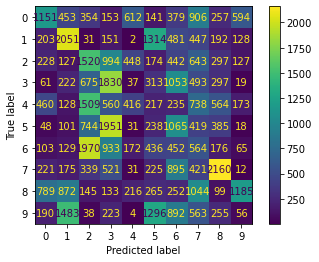

In [80]:
auto_conf = confusion_matrix(auto_gmm_df['Y_true'], auto_gmm_df['Y_pred'])
auto_disp = ConfusionMatrixDisplay(auto_conf)
auto_disp.plot();
print(classification_report(auto_gmm_df['Y_true'], auto_gmm_df['Y_pred']))
print("Autoencoder with GMM Confusion Matrix")

              precision    recall  f1-score   support

           0       0.10      0.08      0.08      5000
           1       0.04      0.06      0.05      5000
           2       0.07      0.05      0.05      5000
           3       0.01      0.00      0.00      5000
           4       0.17      0.15      0.16      5000
           5       0.04      0.04      0.04      5000
           6       0.04      0.06      0.05      5000
           7       0.12      0.18      0.14      5000
           8       0.02      0.02      0.02      5000
           9       0.04      0.03      0.03      5000

    accuracy                           0.07     50000
   macro avg       0.06      0.07      0.06     50000
weighted avg       0.06      0.07      0.06     50000

PCA with GMM Confusion Matrix


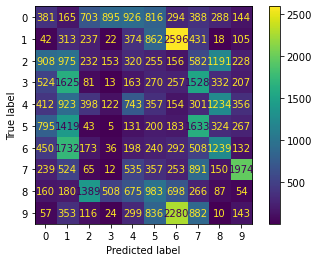

In [81]:
pca_conf = confusion_matrix(pca_gmm_df['Y_true'], pca_gmm_df['Y_pred'])
pca_disp = ConfusionMatrixDisplay(pca_conf)
pca_disp.plot();
print(classification_report(pca_gmm_df['Y_true'], pca_gmm_df['Y_pred']))
print("PCA with GMM Confusion Matrix")